
# Data Processing Example - TRKR

In [54]:
# General imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import experimentdataanalysis.analysis.dataframe_plotting as dfplot

In [55]:
# import jtplot submodule from jupyterthemes IF installed
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=1.6)
    # set the default figure size
    jtplot.figsize(x=6., y=6.)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


## Load data

In [56]:
# Filepath parsing:
import experimentdataanalysis.data_io.metadataparsing as metadataparsing

this_element_keyword_list = [("TRKR", "IsTRKR?", True),
                             ("RSA", "IsRSA?", True)]
next_element_keyword_list = [("Ind", "Scan_2D_Index"),
                             ("2Dscan", ["Scan_2D_Type", "Scan_1D_Type"])]
in_this_element_keyword_list = [("Vcm", "Electric Field (V/cm)"),
                                ("mT", "Magnetic Field (mT)"),
                                ("K", "Set Temperature (K)"),
                                ("nm", "Wavelength (nm)"),
                                ("ps", "Delay Time (ps)"),
                                ("run", "RunIndex"),
                                ("V", "Voltage (V)"),
                                ("x", "Scan_2D_Coord"),
                                ("uWpump", "Pump Power (uW)"),
                                ("uWprobe", "Probe Power (uW)"),
                                ("TestPhaseShift", "TestPhaseShift Experiment #"),
                                ("repeats", "# repeats"),
                               ]
parsing_keyword_lists = [this_element_keyword_list,
                         next_element_keyword_list,
                         in_this_element_keyword_list]

def analyze_filepath_and_header(filepath, header_string, existing_info_dict=None):
    if existing_info_dict is None:
        existing_info_dict = {}
    info_dict = metadataparsing.analyze_scan_filepath(filepath,
                                                      existing_info_dict,
                                                      parsing_keyword_lists)
    metadataparsing.analyze_string_for_dict_pairs(header_string, info_dict)
    if {'Scan_2D_Type', 'Scan_2D_Coord'}.issubset(info_dict.keys()):
        info_dict[info_dict['Scan_2D_Type']] = info_dict['Scan_2D_Coord']
    if 'BExternal' in info_dict.keys():
        info_dict['Magnetic Field (mT)'] = info_dict['BExternal']
    return info_dict

In [59]:
import os

# REQUIRED: directory containing 2D scans
parent_dir = ('C:\\Data\\FitTrialData\\TRFR_RSA')

# REQUIRED: data storage format information
delimiter = '\t'
trailing_delimiters = False  # rows end in delimiters
num_headerlines = 0
column_names_row = 0
overwriting_column_names = ['A', 'B', 'C']

if not overwriting_column_names:
    overwriting_column_names = None
pandas_read_csv_kwargs = {
     'skiprows': num_headerlines,
     'header': column_names_row,
     'names': overwriting_column_names,
     'delimiter': delimiter,
}
if trailing_delimiters:  # needed to avoid problems
    pandas_read_csv_kwargs['index_col'] = False

# REQUIRED: filename key for data files, will load only these
filename_key = '.dat'

# REQUIRED: criteria for grouping runs
# TODO: EXPAND
run_criteria = 'directory'

# OPTIONAL: info_dict-based filtering, fcns returning False if data should be ignored
filter_fcns = [
#                lambda info_dict: info_dict.get("TestPhaseShift Experiment #") == 2,
#                lambda info_dict: info_dict.get("# repeats", 1) <= 2,
#                lambda info_dict: "alignment" not in info_dict.get("Filepath"),
              ]

# OPTIONAL: specify a scalar value to be used as the measurement error of given y-values, i.e., their "error bars"
data_fixed_uncertainty = None


# LOAD AND NOMINALLY FILTER DATA:
unfiltered_filepath_list = []
file_metadata_list = []
file_dataframes_list = []
for dirpath, dirnames, filenames in os.walk(parent_dir):
    for filename in filenames:
        if filename_key in filename:
            unfiltered_filepath_list.append(os.path.join(dirpath, filename))

if run_criteria is not 'directory':
    raise NotImplementedError("currently only supported run criteria is grouping-by-directory")
last_dir = ''
run_counter = -1
filtered_file_list_index = 0
for filepath in unfiltered_filepath_list:
    with open(filepath) as file_lines_iterator:
        header_lines = [next(file_lines_iterator) for line in range(num_headerlines)]
        file_metadata = analyze_filepath_and_header(filepath, ''.join(header_lines))
        file_dataframe = pd.read_csv(filepath_or_buffer=file_lines_iterator,
                                     **pandas_read_csv_kwargs)
        if not all([filter_fcn(file_metadata) for filter_fcn in filter_fcns]):
            continue
        file_dataframe['file_index'] = filtered_file_list_index
        filtered_file_list_index += 1

        # determine Run ID
        if run_criteria == 'directory':
            current_dir = filepath.split('\\')[-2]
            if current_dir != last_dir:
                last_dir = current_dir
                run_counter += 1
            file_metadata['Run ID'] = run_counter
        
        file_dataframes_list.append(file_dataframe)
        file_metadata_list.append(file_metadata)


In [65]:
file_dataframes_list[0].head()

,A,B,C,file_index
0,-500.2216,0.000130,-0.02200,0
1,-475.2909,0.000122,-0.02742,0
2,-450.3601,0.000088,-0.03182,0
3,-425.4294,0.000033,-0.03474,0
4,-400.2216,0.000050,-0.03608,0


In [53]:
file_metadata_list[0]

{'File Last Modified': 'Tue Jun  6 14:45:29 2017',
 'Filepath': 'C:\\Data\\FitTrialData\\TRFR_RSA\\170606DLAY01 Delay_Scan RMBE1130-K_30K_836nm_[1-10]Horiz_0.2T.dat',
 'IsRSA?': True,
 'Run ID': 0,
 'Set Temperature (K)': 30.0,
 'Wavelength (nm)': 836.0}

In [ ]:
# pare down to just data columns what we care about 
# but add all relevant metadata as columns itself

# SEMI-REQUIRED: column-generation options. may be required to prevent loss of important data
# on a level finer than the "run" (e.g. filenames for individual csv's)
info_tag_to_column_list = [('Magnetic Field (mT)', 'b_external'),
                           ('BExternal', 'b_external'),
                           ('Run ID', 'run_id'),
                           ('Scan_2D_Index', 'index_2d'),
                           ('Pump Power (uW)', 'pump_power'),
                           ('Wavelength (nm)', 'wavelength'),
                           ('# repeats', 'n_repeats')
                          ]
time_elapsed_per_delay_scan = 8.0
time_elapsed_per_delay_pos = 1.0
column_expression_list = ['index_2d = index_2d - 1',  # filename convention starts at 1, not at 0 like other indices
                          'index_1d = index',
                          'time_elapsed = ' +
                              '@time_elapsed_per_delay_scan * index_2d + @time_elapsed_per_delay_pos * index_1d',
                         ]

# OPTIONAL: specification of specific columns in data file as x-coords, y-coords. 
#           default: X = 1st column in file, Y = 2nd column in file. 
#                    (or in terms of resulting DataFrame, X = index, Y = 1st column)
data_xfield = None
data_yfield = 'lockin1x'

dataframes_list = []
for file_info_dict, file_dataframe in zip(file_metadata_list, file_dataframes_list):
    column_names = file_dataframe.columns.values.tolist()
    if data_xfield is None:
        data_xfield = column_names[0]
    if data_yfield is None:
        data_yfield = column_names[1]

    # create new dataframe based on user specifications:
    new_dataframe = pd.DataFrame(file_dataframe,
                                 columns=[data_xfield, data_yfield, 'file_index'])
    for info_tag, column_name in info_tag_to_column_list:
        if info_tag in file_info_dict:
            new_dataframe[column_name] = file_info_dict[info_tag]
    for expression in column_expression_list:
        new_dataframe.eval(expression, inplace=True)

    # add new dataframe to list
    dataframes_list.append(new_dataframe)

full_dataframe = pd.concat(dataframes_list)

In [ ]:
TRKR_fit_dataframe = full_dataframe.query('scancoord > 1.0 or scancoord < -1.0')
TRKR_fit_dataframe['n_repeats'].fillna(1.0, inplace=True)
TRKR_fit_dataframe.rename(columns={'scancoord': 'probe_delay'}, inplace=True)
TRKR_fit_dataframe.set_index(['run_id', 'index_2d', 'index_1d'], drop=True, append=False, inplace=True)
TRKR_fit_dataframe.sort_index(ascending=True, inplace=True)
df = TRKR_fit_dataframe
TRKR_fit_dataframe.head(20)

## Pandas-lmfit helper functions

In [4]:
from experimentdataanalysis.analysis.dataframe_processing \
    import df_extract_dataset_indexed_matrices, \
           df_extract_vector_lists_by_dataset, \
           df_transform_dataset_df_to_fit_row, \
           df_minimize_fcn_on_datasets, \
           df_minimize_fcn_across_linked_datasets

# df_extract_dataset_indexed_matrices(df, column_names)
# df_extract_vector_lists_by_dataset(df, column_names)
# df_transform_dataset_df_to_fit_row(df, group_fit_params_dict,
#                                    fit_params_to_add,
#                                    column_aggregation_dict={},
#                                    keep_const_columns=True)
# df_minimize_fcn_on_datasets(df, residuals_fcn, fit_params,
#                             independent_vars_columns,
#                             measured_data_column,
#                             *res_args,
#                             column_aggregation_dict={},  # KEYWORDS ONLY!
#                             keep_const_columns=True,
#                             **res_kwargs)

# WORK IN PROGRESS:
# df_minimize_fcn_across_linked_datasets(df, residuals_fcn, fit_params,
#                                        dataset_params_unpacking_fcn,
#                                        independent_vars_columns,
#                                        measured_data_column,
#                                        *res_args,
#                                        column_aggregation_dict={},  # KEYWORDS ONLY!
#                                        keep_const_columns=True,
#                                        **res_kwargs)

## Dataset fit model and residuals

In [5]:
# GLOBAL CONSTANTS
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period

def fitfcn_cosine(delay_time, b_external,  # <- independent vars,
                  gfactor,  # <- potentially linked parameters across datasets in run,
                  amplitude, phase_offset,  # <- rest are unlinked parameters unique to current dataset
                  y_offset):
    """
    Oversimplified cosine fit that assumes phase @t=0 is always 0.
    Expected to act on very few data points, so brings in expected ang. freq using b_external.

    Independent variables: delay_time (can vary), b_external (must be const.)
    Parameters: gfactor, amplitude, phase_offset, y_offset

    IMPORTANT NOTE: Despite this function taking more than one independent variable,
    this model is ONLY 1D. Only the first should be allowed to vary during a run,
    the other independent variables are there for convenience when fitting to pandas
    dataframes and should really be thought of more as constant parameters (scalar
    values are not only acceptable, they are preferred for speed reasons to the
    alternative - arrays of same shape as first independent variable)
    """
    osc_ang_freq = 2 * np.pi * GFACTORCONSTANT * gfactor * b_external
    pos_def_delay = delay_time % LASER_REPRATE
    signal = amplitude * np.cos(osc_ang_freq * pos_def_delay + phase_offset)
    return signal + y_offset


def residuals_fitfcn_cosine(params, delay_time, b_external, measured_data=None):
    """
    Residual wrapper for lmfit minimize() for function fitfcn_cosine.
    Uses given parameters and independent variables to evaluate function.
    If data is given, returns (data - function_output) for use in least
    squares optimization. If data is not given or None, just returns
    the function output.

    Follows the style used in the lmfit documentation on minimize().
    """
    # unpack parameters:
    #  extract .value attribute for each parameter
    param_values = params.valuesdict()
    gfactor      = param_values['gfactor']
    amplitude    = param_values['amplitude']
    phase_offset = param_values['phase_offset']
    y_offset     = param_values['y_offset']
    fitfcn_results = fitfcn_cosine(delay_time, b_external,
                                   gfactor, amplitude, phase_offset, y_offset)
    if measured_data is None:
        return fitfcn_results
    return fitfcn_results - measured_data

## Dataset fit parameter setup and constraints

In [6]:
from lmfit import Parameters

params_guesses = [('gfactor',        {'value' : 0.439,
                                      'vary'  : False}),
                  ('amplitude',      {'value' : 1e-3,
                                      'min'   : 0.0,
                                      'max'   : 1.0}),
                  ('phase_offset',   {'value' : 0.0,
                                      'min'   : -np.pi,
                                      'max'   : +np.pi}),
                  ('y_offset',       {'value' : 0.0,
                                      'min'   : -1e-3,
                                      'max'   : +1e-3}),
                 ]
fit_params = Parameters()
for param_name, param_guess_dict in params_guesses:
    fit_params.add(param_name, **param_guess_dict)

## 1D Fit to fake data

,b_external,gfactor,amplitude,amplitude_error,phase_offset,phase_offset_error,y_offset,y_offset_error
index_2d,,,,,,,,
0,200.0,0.439,0.000256,0.000010,0.064644,0.045980,6.133498e-05,0.000009
1,200.5,0.439,0.000344,0.000009,0.102193,0.022174,2.235081e-04,0.000007
2,201.0,0.439,0.000237,0.000015,0.245262,0.035119,6.342757e-07,0.000010
3,201.5,0.439,0.000264,0.000009,0.261825,0.016268,3.467772e-05,0.000006
4,202.0,0.439,0.000238,0.000017,0.311932,0.039501,-1.068474e-05,0.000012


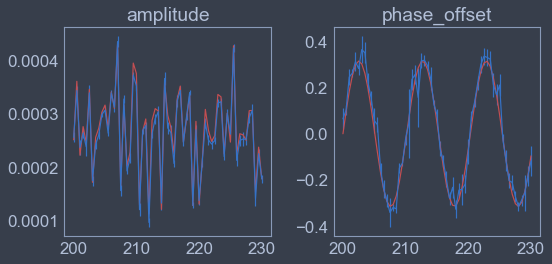

In [7]:
df = dataframe.xs(0, level='run_id')
residuals_fcn = residuals_fitfcn_cosine
fit_params = fit_params
independent_vars_columns = ["probe_delay", "b_external"]
measured_data_column = "kerr_rotation"
fit_params_to_add = ['amplitude', 'phase_offset']
column_aggregation_dict = {'time_elapsed': lambda x: x.head(1).values}  # keep first time
keep_const_columns = True

dataset_results, new_df = \
    df_minimize_fcn_on_datasets(df, residuals_fcn, fit_params,
                                independent_vars_columns,
                                measured_data_column,
                                column_aggregation_dict=column_aggregation_dict,  # keywords only!
                                keep_const_columns=keep_const_columns)

# FILTER OUT BAD FITS
good_result_indices = []
for dataset_index, result in enumerate(dataset_results):
    red_flag = False
    if result.params['phase_offset'].stderr > np.pi / 2:
        print("dataset {}: ".format(dataset_index) +
              "phase offset error too large, ignoring dataset...")
        red_flag = True
    if not red_flag:
        good_result_indices.append(dataset_index)
trimmed_df = new_df.iloc[good_result_indices]

# GET ACTUAL RESULTS FROM SIMULATION TO COMPARE
true_spin_lifetimes = simulation_params['spin_lifetimes'][good_result_indices]
n500ps_decay_factors = np.exp(-(LASER_REPRATE - 500.0) / true_spin_lifetimes)
true_amplitudes = n500ps_decay_factors * simulation_params['pulse_amplitudes'][good_result_indices]
true_phase_offsets = simulation_params['extra_phase_offsets'][good_result_indices]

plt.figure(figsize=(8,4))
ax1 = plt.subplot(1,2,1)
plt.plot(trimmed_df.b_external, true_amplitudes, 'r')
plt.errorbar(x=trimmed_df.b_external, y=trimmed_df.amplitude, yerr=trimmed_df.amplitude_error)
# new_df['amplitude'].plot.line(ax=ax1)
plt.title('amplitude')
ax2 = plt.subplot(1,2,2)
plt.plot(trimmed_df.b_external, true_phase_offsets, 'r')
plt.errorbar(x=trimmed_df.b_external, y=trimmed_df.phase_offset, yerr=trimmed_df.phase_offset_error)
# new_df['phase_offset'].plot.line(ax=ax2)
plt.title('phase_offset')
new_df.head()

# indices_to_show = [0, 1]
# for dataset_index in indices_to_show:
#     if dataset_index not in good_result_indices:
#         print("Error: index {} does not exist ".format(dataset_index) +
#               "or fit was unsuccessful")
#     else:
#         dataset_df = df.loc[]
#         fit_result = dataset_results[dataset_index]
#         try:
#             fit_result.plot()  # REQUIRES A MODEL FIT, NOT MINIMIZER FIT!
#         except AttributeError:  # note: assumes standard lmfit fitfcn form
#             raise NotImplementedError()
#             x_vectors = [df.
#                          for colname in independent_vars_columns]
#             fit_yvals = residuals_fcn(fit_result.params,
                                      

In [8]:
result = dataset_results[0]
result.chisqr

4.9250930534441784e-09